# Customer Insights

## Customer No-Show / Cancellation Prediction Application

In [ ]:
%run CIApplication.py

Finished installing packages
 
Training Data
Importing Data and training model
(Approximately 4 minutes)
-data imported
--client data filtered
---client data prepared
----appointment data prepared
-----client data joined to appointment data
------data prepared
-------data normalized
--------data split into training and test samples
---------training data resampled
 
training and calibrating Random Forest (approximately: 1.5 minutes)
...
random forests trained and calibrated
 
No-Show AUC-ROC: 0.69292656587473
Cancellation AUC-ROC: 0.6566089306553652
 
running cross-validation test on No-Show Model (approximately: 1 minute)
...


## Instructions

### Application Instructions

1. Launch the application above by clicking the code cell that says "%run CIApplication.py," then press the play button icon above to run it.
   - This will launch the CIApplication.py file, seen in the file explorer on the left.
   - First, it will install any necessary packages to run the application.
   - Second, it is going to import the CSV files Clients.csv and Appointments.csv, prepare them, and then train the machine-learning model
   - Third, it will open the User Form to enter data to build prediction.
   - The application will print statements throughout the process to inform you of its progress.
<br><br>
2. Enter data in the UserForm, then click the button that says "Make Prediction."
   - This will take any data you entered, run it through the trained model, display the chances of No-Shows and Cancellations, and display some data plots.
   - Information can be left blank. If information is left blank, it will be filled with modes for those characteristics to run the model.
<br><br>
3. In the Tab widget, click through each tab to see information about the data.
<br><br>
4. You can enter new data into the UserForm and click "Make Prediction" again to display a new prediction.
<br><br>
<i>Note: Instead of launching the application using the play button, you can use the fast forward button, which will also run all codes below in advance.<br>
But you cannot make a prediction using the Application until all code cells below have finished running.<br>
If you click "Make Prediction" before the cells have finished running, it will process the prediction once the other cells have finished.</i>

### Code Walkthrough Instructions

Below is a code walkthrough that walks you through my code process on how I:
- Prepared the data
- Trained the machine learning model
- Created plots

As you read through this notebook, click on each code cell, then click the play button at the top of the page to run the code cell and display the output.<br>
After running a code cell, a print statement will be shown to help indicate that the code cell has finished running.<br>
<br>
There is a lot of code, so if at any point you get lost, access the table of contents on the left side (icon with 3 bars).
<br>
<br>
<i>Note: You can also click the fastforward button at the top of the page to restart the kernel and run all cell in advance.<br>
But, the cells below won't run until the code cell above has finished running.</i>

## Purpose of Application

The purpose of this application is to predict the chance of a Customer canceling the appointment or not showing up to the appointment (No-Show). <br>
This application uses a calibrated Random Forest Classification machine-learning model trained on client and appointment data. <br>
<br>
I built this application to test the hypothesis that the no-shows and cancellations are driven mainly by the <b>Age</b> of customers.<br>
<br>
Note:<br>
<i>The full original program to build and test this code can be found in CustomerInsights.py.<br>
If you run CustomerInsights.py, it will run the full code and make a prediction using randomized input.<i>

## Code Walkthrough

### Download Packages

First, we need to ensure all the packages required to run this application are installed.<br>
<br>
The packages that this application is dependent on are:
- pandas       (Data importing and preparation)
- imblearn     (Balance data via oversampling and undersampling)
- scikit-learn (Train and verify machine-learning model)
- matplotlib   (Visualizations)
- seaborn      (Visualizations)

In [2]:
import importlib.util
import subprocess
import sys

def install_and_import(package):
    if importlib.util.find_spec(package) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    else:
        print(f"{package} is already installed")

install_and_import('pandas')
install_and_import('matplotlib')
install_and_import('seaborn')
install_and_import('scikit-learn')
install_and_import('imblearn')

print('')
print('Finished installing packages')

pandas is already installed
matplotlib is already installed
seaborn is already installed
imblearn is already installed

Finished installing packages


### Import Libraries

Next, we will import all of the libraries this application uses.

In [3]:
# %% Import libraries

import pandas as pd
import warnings as warn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.calibration import CalibratedClassifierCV
from datetime import datetime
from imblearn.combine import SMOTETomek
import random as rand

print('Libraries imported')

Libraries imported


### General Declarations

A few general declarations which will be used throughout the application will be assigned here before moving on. 

In [4]:
# %% General Declarations

col_index = None #Holds column index
ds = None        #Holds currently worked on data slice
df = None        #Holds currently worked on data frame

print('General Declarations assigned')

General Declarations assigned


### Data Preparation

#### Import Data

We need to import the CSV files we will be working with:
- Clients.csv
- Appointments.csv

The files were prepared before being brought into this application by:
- Removing personally identifying information to maintain HIPAA compliance
- Correct data inconsistencies that would be more difficult to manage with code
- Filled null values that can be deduced from other columns

In [5]:
# %% Load Raw Data (csv)

clientData_raw = pd.read_csv("Clients.csv")
appointmentData_raw = pd.read_csv("Appointments.csv")

print('Data imported')

Data imported


#### Filter out bad data

Because many of the clients in the client data file were inherited from a previous application, most of the data is not assigned to any appointments, which would lead to a bad model.<br>
We will correct this by checking each client account number to see if it exists anywhere in the appointment data.<br>
If not, the client will be removed.

In [6]:
# %% Filter out clients with no appointment data and reset index

clientData_filtered = clientData_raw[clientData_raw['Account_Number']
                                     .isin(appointmentData_raw['Account_Number'])]
clientData_filtered = clientData_filtered.reset_index(drop=True)

# Make copy of filtered data to preprocess
clientData = clientData_filtered.copy()

print('Client data filtered')

Client data filtered


#### Ignore warnings

Before cleaning the data further, we are going to disable some warning we might get while running the code due to the packages being used.<br>
While this may be bad practice, the application has been test and this will not cause any harm.

In [7]:
# %% ignore warnings

warn.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warn.filterwarnings("ignore", category=UserWarning, module="sklearn")

print('Warnings disabled')

Warnings disabled


#### Prepare client data

We are going to prepare the client data by doing the following:
- Convert non-numerical values to Integers
    - Logically binary data will be 0s and 1s
    - Other data will start at 1
- Calculate Age from Birth_Year
- Remove columns that will not be used to train the model
- Null values will be randomly assigned based on value frequencies.

The data is prepared when the data is complete, and the only columns left are:
- Account_Number
- Zip
- Sex
- Age
- Marital
- Employment
- Accident
- Num_Appts

##### Rename columns based on use

In [8]:
# %% rename columns

# Rename 'Sex' to 'c_Sex' so that I can reuse 'Sex'
clientData.rename(columns={'Sex': 'c_Sex'}, inplace=True)

# Rename 'Zip_PostalCode' to 'Zip' to shorten name or ease of use
clientData.rename(columns={'Zip_PostalCode': 'Zip'}, inplace=True)

# Rename 'Number_of_Appointments' to 'Num_Appts' to shorten length
clientData.rename(columns={'Number_of_Appointments': 'Num_Appts'},
                  inplace=True)

print('Columns renamed')

Columns renamed


##### Convert data to all numerical values

In [9]:
# If sex is M then 1, if F then 2, else nan
ds = clientData['c_Sex']
clientData.loc[:, 'Sex'] = np.where(ds == 'M', 1, #Male
                           np.where(ds == 'F', 2, #Female
                           np.where(ds == 'O', 3, #Other
                           np.nan)))              #No Entry

# Get index of c_Sex and move Sex behind it
col_index = clientData.columns.get_loc('c_Sex')
clientData.insert(col_index + 1, 'Sex', clientData.pop('Sex'))

# %% Add column 'Age' to clientData and calculate 'Age' from Birth_Year

# Get current year
current_year = datetime.now().year

# Where Birth_Year is 1900, age is nan, else age = currentYear - BirthYear
clientData.loc[:, 'Age'] = np.where(clientData['Birth_Year'] == 1900,
                           np.nan,
                           current_year - clientData['Birth_Year'])

# Get index of BirthYear and move 'Age' behind it
col_index = clientData.columns.get_loc('Birth_Year')
clientData.insert(col_index + 1, 'Age', clientData.pop('Age'))

# %% Convert Martial Status to Integers

# Convert Material Statuses to integers, else nan
ds = clientData['Marital_Status']
clientData.loc[:, 'Marital'] = np.where(ds == 'M', 1, #Married
                               np.where(ds == 'C', 2, #Common-Law
                               np.where(ds == 'D', 3, #Divorced
                               np.where(ds == 'W', 4, #Widowed
                               np.where(ds == 'S', 5, #Single
                               np.where(ds == 'O', 6, #Other
                               np.nan))))))           #No Entry

# Get index of 'Marital_Status' and move 'Marital' behind it
col_index = clientData.columns.get_loc('Marital_Status')
clientData.insert(col_index + 1, 'Marital', clientData.pop('Marital'))

# %% Convert Employment Status to Integers

# Convert Employment_Status to integers, else nan
ds = clientData['Employment_Status']
clientData.loc[:, 'Employment'] = np.where(ds == 'E', 1,  #Employed
                                  np.where(ds == 'S', 2,  #Student
                                  np.where(ds == 'R', 3,  #Retired
                                  np.where(ds == 'UE', 4, #Unemployed
                                  np.where(ds == 'O', 5,  #Other
                                  np.nan)))))             #No Entry

# Get index of 'Employment_Status' and move 'Employment' behind it
col_index = clientData.columns.get_loc('Employment_Status')
clientData.insert(col_index + 1, 'Employment', clientData.pop('Employment'))

# %% Convert 'Is condition due to an accident' to integers

# Convert 'Is_condtion_due_to_an_accident' to binary integers, else nan
ds = clientData['Is_condition_due_to_an_accident']
clientData.loc[:, 'Accident'] = np.where(ds == "[u'No']", 0,  #No
                                np.where(ds == 'No', 0,       #No
                                np.where(ds == "[u'Yes']", 1, #Yes
                                np.where(ds == 'Yes', 1,      #Yes
                                np.nan))))                    #No Entry

# Get index of 'Is_condition_due_to_an_accident' and move"Accident" behind it
col_index = clientData.columns.get_loc('Is_condition_due_to_an_accident')
clientData.insert(col_index + 1, 'Accident', clientData.pop('Accident'))

print('Data converted')

Data converted


##### Remove Unused columns

In [10]:
# %% Remove unused columns

del clientData['City']
del clientData['State_Province']
del clientData['Country']
del clientData['c_Sex']
del clientData['Birth_Year']
del clientData['Marital_Status']
del clientData['Employment_Status']
del clientData['Is_condition_due_to_an_accident']
del clientData['Reminder_Preference']
del clientData['Subscribed_Reminders']
del clientData['Subscribed_Recalls']
del clientData['Subscribed_Email_Campaigns']
del clientData['Subscribed_Birthday_Campaigns']
del clientData['Subscribed_Availability_Campaigns']
del clientData['Subscribe_Referral_Campaigns']
del clientData['Subscribe_Client_Satisfaction']

print('Columns removed')

Columns removed


##### Randomly assign null data with values

In [11]:
# %% Randomly assign values to NaNs based on Frequency of values in same column

# Fills NaNs based on how often other values in a column occur to maintain distribution
def fill_na_with_frequencies(series, value_counts):
    na_indices = series[series.isna()].index
    fill_values = np.random.choice(value_counts.index, size=len(na_indices), p=value_counts.values)
    series.loc[na_indices] = fill_values
    return series

# Zip Codes
ds = clientData['Zip']
value_counts = ds.value_counts(normalize=True)
ds = fill_na_with_frequencies(ds, value_counts)

# Sex
ds = clientData['Sex']
value_counts = ds.value_counts(normalize=True)
ds = fill_na_with_frequencies(ds, value_counts)

# Age
ds = clientData['Age']
value_counts = ds.value_counts(normalize=True)
ds = fill_na_with_frequencies(ds, value_counts)

# Marital_Status
ds = clientData['Marital']
value_counts = ds.value_counts(normalize=True)
ds = fill_na_with_frequencies(ds, value_counts)

# Employment_Status
ds = clientData['Employment']
value_counts = ds.value_counts(normalize=True)
ds = fill_na_with_frequencies(ds, value_counts)

# Is condition caused by accident
ds = clientData['Accident']
value_counts = ds.value_counts(normalize=True)
ds = fill_na_with_frequencies(ds, value_counts)

print('Null values filled')
print(' ')
print(clientData)

Null values filled
 
     Account_Number      Zip  Sex   Age  Marital  Employment  Accident  \
0              3303  98403.0  2.0  78.0      1.0         3.0       0.0   
1              3043  98406.0  2.0  68.0      1.0         3.0       0.0   
2               136  98467.0  2.0  64.0      1.0         1.0       0.0   
3              4913  98467.0  1.0  59.0      1.0         1.0       0.0   
4              4795  98409.0  1.0  33.0      1.0         2.0       0.0   
..              ...      ...  ...   ...      ...         ...       ...   
478            4811  98467.0  2.0  38.0      5.0         1.0       1.0   
479            3645  98498.0  2.0  73.0      3.0         3.0       0.0   
480            4886  98023.0  2.0  44.0      1.0         5.0       0.0   
481            4975  98445.0  1.0  71.0      1.0         3.0       0.0   
482            4976  98445.0  2.0  65.0      1.0         3.0       0.0   

     Num_Appts  
0          2.0  
1          9.0  
2          3.0  
3          2.0  
4    

##### --Zip Code distribution--

Here's a bar diagram of the distribution of Zip codes where clients live.<br>
I chose this visualization because after training the data, we learned that Zip Codes had the most impact on our predictions (<i>shown later</i>).<br>
This came as a surprise to us and disproved our hypothesis that age had the most significant impact.

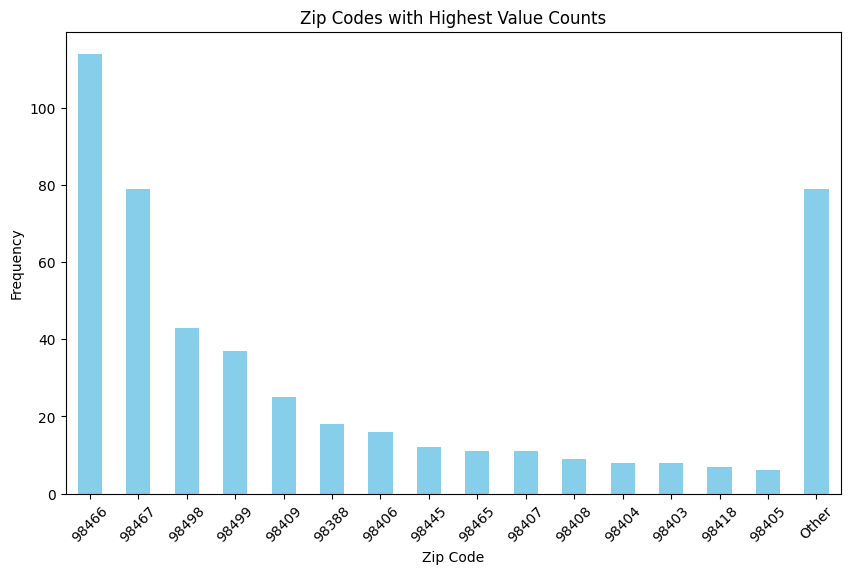

In [12]:
# %% Zip Codes visualization

# Get zip code counts
zip_counts = clientData['Zip'].astype(int).value_counts()
top_15 = zip_counts.nlargest(15)
Other = zip_counts.iloc[15:].sum()
top_15['Other'] = Other

# Set up plot
plt.figure(figsize=(10, 6))
top_15.plot(kind='bar', color='skyblue')
plt.xlabel('Zip Code')
plt.ylabel('Frequency')
plt.title('Zip Codes with Highest Value Counts')
plt.xticks(rotation=45)
plt.show()

#### Prepare Appointment Data

We are going to prepare the client data by doing the following:
- Convert the Date Timestamp to DateTime format
- Extract Year, Quarter, Month, Day_of_Week, Day, and Hour from the Date
- Convert non-numerical values to Integers
    - Logically binary data will be 0s and 1s
    - Other data will start at 1
    - Length will represent the length of the appointment in minutes (30, 60, 90)
- Adding columns 'No_Show' and 'Cancelled'
- Remove columns that will not be used to train the model
- Null values will be randomly assigned based on value frequencies.

The data is prepared when the data is complete, and the only columns left are:
- Account_Number
- Practitioner
- Year
- Quarter
- Month
- Day_of_Week
- Day
- Hour
- Service
- No_Show
- Cancelled

##### Rename columns based on use

In [13]:
# %% Copy AppointmentData_raw

appointmentData = appointmentData_raw.copy()

# %% Rename columns

# Rename 'Service' to 'a_Service' so that 'Service' can be reused
appointmentData.rename(columns={'Service': 'a_Service'}, inplace=True)

# Rename 'Status' to 'a_Status' so that 'Status' can be reused
appointmentData.rename(columns={'Status': 'a_Status'}, inplace=True)

print('Columns renamed')

Columns renamed


##### Extract Date information

In [14]:
# %% Set appointmentData[Date] to Datetime format

appointmentData['Date'] = pd.to_datetime(appointmentData['Date'], format='%b %d, %Y @ %I:%M%p')

# %% Extract Pieces of DateTime object and add columns for them

# Extract Year, Quarter, Month, DayOfWeek, and Hour and add columns
appointmentData['Year'] = appointmentData['Date'].dt.year
appointmentData['Quarter'] = appointmentData['Date'].dt.quarter
appointmentData['Month'] = appointmentData['Date'].dt.month
appointmentData['Str_Day_of_Week'] = appointmentData['Date'].dt.day_name()
appointmentData['Hour'] = appointmentData['Date'].dt.hour

# convert Day_of_Week to Integer Format
ds = appointmentData['Str_Day_of_Week']
appointmentData.loc[:, 'Day_of_Week'] = np.where(ds == 'Sunday', 0,
                                        np.where(ds == 'Monday', 1,
                                        np.where(ds == 'Tuesday', 2,
                                        np.where(ds == 'Wednesday', 3,
                                        np.where(ds == 'Thursday', 4,
                                        np.where(ds == 'Friday', 5,
                                        np.where(ds == 'Saturday', 6,
                                        np.nan)))))))

# Get index of 'Str_Day_of_Week' and insert 'Day_of_Week' behind it
col_index = appointmentData.columns.get_loc('Str_Day_of_Week')
appointmentData.insert(col_index + 1, 'Day_of_Week', appointmentData.pop('Day_of_Week'))

print('Date information extracted')

Date information extracted


##### Create array of services

In [15]:
# %% List Services to help convert to Integer format

services = ['30 minute 30 Minute Add-On',
            '60 minute Deep Tissue Massage',
            '60 minute Relaxation Massage',
            '60 minute Pregnancy Massage',
            '60 minute Insurance Massage',
            '60 minute Pregnancy Insurance Massage',
            '60 minute L&amp;I Massage',
            '60 minute Motor Vehicle Accident (MVA) Massage',
            '90 minute Deep Tissue Massage',
            '90 minute Relaxation Massage',
            '90 minute Insurance Massage',
            '90 minute Pregnancy Insurance Massage'
            ]

print('Service Array Created')

Service Array Created


##### Convert Data to Integers

In [16]:
# %% Convert Services to integers

# Search for a value in array and return index
def find_index(value, array):
    try:
        return array.index(value)
    except ValueError:
        return -1

# Add column 'Service' and convert values to Integers base on index in
# services[] sharing same value
ds = appointmentData['a_Service']
appointmentData['Service'] = ds.apply(lambda x: find_index(x, services))

# %% Add column 'Length' with values based on length of services in minutes

# Search for value in array return integer based on index of value
def find_length(value, array):
    try:
        arg_30 = (array.index(value) == 0)
        arg_60 = ((array.index(value) >= 1) and (array.index(value) <= 7))
        arg_90 = ((array.index(value) >= 8) and (array.index(value) <= 11))
        
        if arg_30:
            return 30
        if arg_60:
            return 60
        if arg_90:
            return 90
    except ValueError:
        np.nan
   
# Add column 'Length' and assign each row an integer that reflect the length
# of that appointments service provided in minutes
ds = appointmentData['a_Service']
appointmentData['Length'] = ds.apply(lambda x: find_length(x, services))

# %% Add column 'Insurance' with integer based on if service is an
#    insurance massage

# Search for value in array and return binary Integer based on index of value
def find_insurance(value, array):
    try:
        arg_0_1 = ((array.index(value) >= 0) and (array.index(value) <= 3))
        arg_0_2 = ((array.index(value) >= 8) and (array.index(value) <= 9))
        arg_1_1 = ((array.index(value) >= 4) and (array.index(value) <= 7))
        arg_1_2 = ((array.index(value) >= 10) and (array.index(value) <= 11))
        
        if (arg_0_1 or arg_0_2):
            return 0
        if (arg_1_1 or arg_1_2):
            return 1
    except ValueError:
        np.nan

# Add column 'Insurance' and assign each row a binary Integer based on if the
# service of that appointment is an insurance massage
ds = appointmentData['a_Service']
appointmentData['Insurance'] = ds.apply(lambda x: find_insurance(x, services))

# %% Add column 'Status' and assign Integer based on appointments Status

ds = appointmentData['a_Status']
appointmentData.loc[:, 'Status'] = np.where(ds == 'PAID', 1,
                                       np.where(ds == 'DUE', 1,
                                       np.where(ds == 'CANCELLED', 2,
                                       np.where(ds == 'NO SHOW', 3,
                                       np.nan))))

print('Data converted')

Data converted


##### Add No-Shows and Cancellations

In [17]:
# %% Add column 'No_Show' and assign Binary Integer based on if the client
#    No-Showed the appointment

ds = appointmentData['a_Status']
appointmentData.loc[:, 'No_Show'] = np.where(ds == 'NO SHOW', 1, 0)

# %% Add column 'Cancellation' and assign Binary Integer based on if the
#    client cancelled the appointment

ds = appointmentData['a_Status']
appointmentData.loc[:, 'Cancelled'] = np.where(ds == 'CANCELLED', 1, 0)

print('No_Show and Cancelled added')

No_Show and Cancelled added


##### Deleted unused Columns

In [18]:
# %% Remove unused columns

del appointmentData['Date']
del appointmentData['Str_Day_of_Week']
del appointmentData['a_Service']
del appointmentData['a_Status']

print('Columns deleted')
print('')
print(appointmentData)

Columns deleted

      Account_Number  Practitioner  Year  Quarter  Month  Day_of_Week  Hour  \
0                122             3  2022        2      6          5.0     9   
1                122             3  2022        2      5          5.0     9   
2                122             3  2022        2      4          5.0     9   
3                122             3  2022        1      3          2.0     9   
4                122             3  2022        1      3          2.0    11   
...              ...           ...   ...      ...    ...          ...   ...   
4818            1008             1  2023        4     10          4.0    14   
4819            4762             1  2022        4     12          4.0     9   
4820            4762             1  2022        3      9          2.0     9   
4821            4762             1  2022        3      9          2.0    12   
4822               3             1  2022        1      1          1.0    11   

      Service  Length  Insurance  

##### --Appointment Status Distribution--

Here, we will display a pie chart showing the distribution of completed appointments compared to No-Shows and Cancellations.<br>
<br>
We can see that about a fifth of appointments are canceled or no-shows, with cancellations making up most of the fifth.<br>
So, while initially, we focused on developing this application to help develop business strategies to prevent no-shows, it looks as though we should move our focus to cancellations.

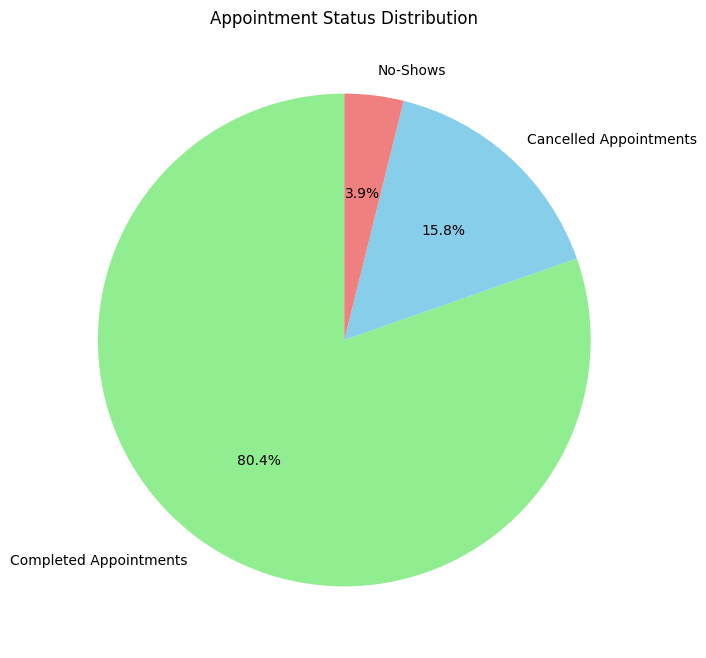

In [19]:
# %% Status visualization

# Get counts of each status
status_counts = appointmentData['Status'].value_counts()

# Create custom labels
custom_labels = ['Completed Appointments', 'Cancelled Appointments', 'No-Shows']

# Set up plot
plt.figure(figsize=(8,8))
status_counts.plot.pie(labels=custom_labels, autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'skyblue', 'lightcoral'])
plt.title('Appointment Status Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

#### Join Data

Now, the prepared client data and appointment data need to be joined together to make a single dataset.<br>
We will do this by joining the client data to the appointment data using account_number.<br>
Afterwards, the account numbers can be removed.

In [20]:
# %% Join dataframes and remove columns that may reduce accuracy

# join clients table to appointments table by account number
joinedData = pd.merge(appointmentData, clientData, on='Account_Number', how='left')

# remove account numbers
del joinedData['Account_Number']

print('Data joined')
print(' ')
print(joinedData)

Data joined
 
      Practitioner  Year  Quarter  Month  Day_of_Week  Hour  Service  Length  \
0                3  2022        2      6          5.0     9        1      60   
1                3  2022        2      5          5.0     9        1      60   
2                3  2022        2      4          5.0     9        4      60   
3                3  2022        1      3          2.0     9        4      60   
4                3  2022        1      3          2.0    11        4      60   
...            ...   ...      ...    ...          ...   ...      ...     ...   
4818             1  2023        4     10          4.0    14        4      60   
4819             1  2022        4     12          4.0     9        4      60   
4820             1  2022        3      9          2.0     9        4      60   
4821             1  2022        3      9          2.0    12        4      60   
4822             1  2022        1      1          1.0    11        4      60   

      Insurance  Status  

##### --Status of appointment by Age Group--

Here, we will show a bar plot showing the status of appointments by age group.<br>
<br>
The visualization shows that individuals around retirement age make a majority of appointments.<br>
It also shows that Completed appointments compared to No-Shows and Cancellations are proportionate across each age group.<br>
<br>
We see that no-shows and cancellations increase on the chart's far ends, indicating that the retirement group makes the most appointments.<br>
This shows that age does play some factor, as stated in our hypothesis, but not as much as expected.

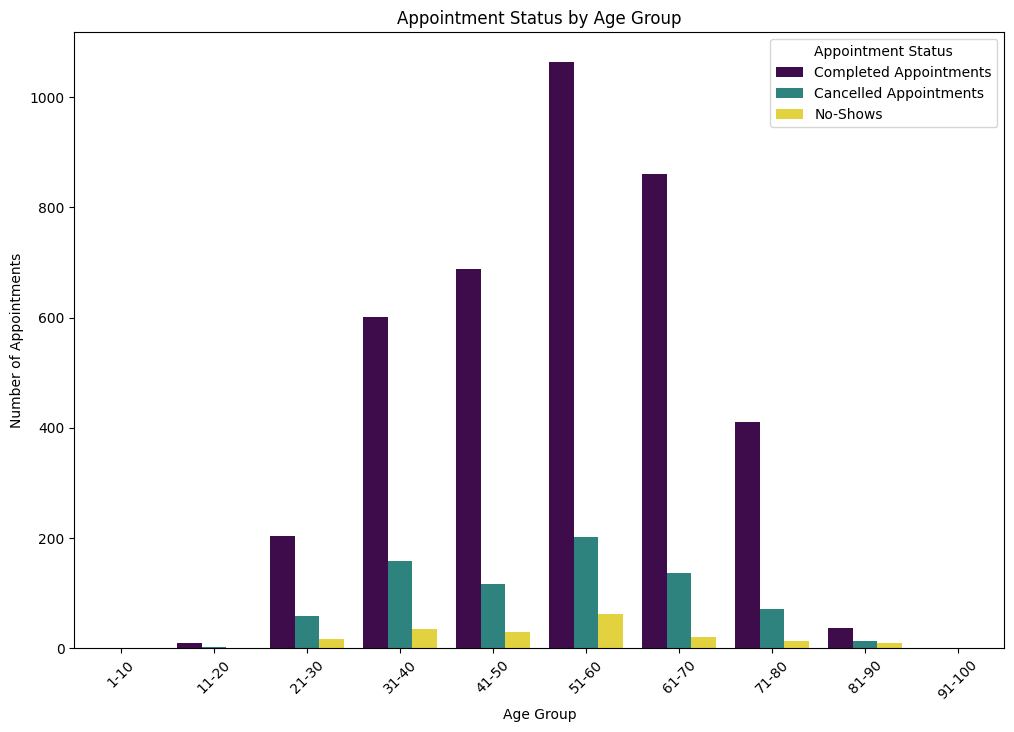

In [21]:
# %% Age Buckets visualization

df = joinedData

# Create age buckets
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['1-10', '11-20', '21-30', '31-40', '41-50',
          '51-60', '61-70', '71-80', '81-90', '91-100']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Count the occurrences of each status within each age bucket
age_status_counts = df.groupby(['Age_Group', 'Status'], observed=False).size().reset_index(name='Count')

# Plot the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(data=age_status_counts, x='Age_Group', y='Count', hue='Status', palette='viridis')
plt.xlabel('Age Group')
plt.ylabel('Number of Appointments')
plt.title('Appointment Status by Age Group')
plt.xticks(rotation=45)

# Change Key names in legend
new_labels = ['Completed Appointments', 'Cancelled Appointments', 'No-Shows']
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, new_labels, title='Appointment Status')

plt.show()

del df['Age_Group']

### Train Model

The data has been prepared, and we can train our machine-learning model now.<br>
<br>
The model we will be using is the Random Forest Classifier model.<br>
Our dataset is small, and Random Forest will help prevent overfitting data.<br>
<br>
We will train our model by:
- Removing any leftover columns that may negatively affect training (this took some trial and error)
- Setting our dependent variable
- Splitting our data into a training set and test set
    - A 9:1 split worked best for our data
- Apply SMOTETomek to resample and balance data
- Train model
    - We're going to be using a calibrated Random Forest Classifier model (CalibratedClassifierCV)

We will train two models, one for No-Shows and one for Cancellations.

#### Remove unwanted columns
We will remove any columns that may negatively affect data, usually due to being not as relevant as the rest of the data.<br>
Status will be assigned to a variable so we can use it later for visualizations.

In [22]:
# %% Remove Unwanted columns

status = joinedData.pop('Status') # saving this for visualization
del joinedData['Year']
del joinedData['Num_Appts']

print('Unwanted columns removed')

Unwanted columns removed


#### Copy Joined data into two sets
We are going to copy joined data into two sets.<br>
<br>
One set will be for No-Shows, shown with a '_n' at the end of the assignment.<br>
The second set will be for Cancellations, shown with a '_c' at the end of the assignment.<br>
<br>
We will continue the criteria as we advance to differentiate the datasets.

In [23]:
# %% Copy joinedData to train to different models, one for No_Show and one
#    for Cancellations and remove their opposing columns

# DataFrame to predict No_Show
joinedData_n = joinedData.copy()
del joinedData_n['Cancelled']

# DataFrame to predict Cancellation
joinedData_c = joinedData.copy()
del joinedData_c['No_Show']

print('joinedData copied')

joinedData copied


#### Normalize data
Now, we will normalize the data to improve model performance by taking the smallest values and largest values from each column and squishing them down to a range from 0 to 1.<br>
<br>
We chose this method instead of using a StandardScaler() because the standard scaler had outliers that were too large and led to bad predictions.

In [24]:
# %% Normalize dataframes to range between 0 and 1

# assign for normalizing
# these will be used later on user input
jdn = joinedData_n
jdc = joinedData_c

# normalize
joinedData_n = (jdn - jdn.min()) / (jdn.max() - jdn.min())
joinedData_c = (jdc - jdc.min()) / (jdc.max() - jdc.min())

print('Data normalized')
print(' ')
print(joinedData_n)

Data normalized
 
      Practitioner   Quarter     Month  Day_of_Week      Hour   Service  \
0              1.0  0.333333  0.454545          0.8  0.071429  0.090909   
1              1.0  0.333333  0.363636          0.8  0.071429  0.090909   
2              1.0  0.333333  0.272727          0.8  0.071429  0.363636   
3              1.0  0.000000  0.181818          0.2  0.071429  0.363636   
4              1.0  0.000000  0.181818          0.2  0.214286  0.363636   
...            ...       ...       ...          ...       ...       ...   
4818           0.0  1.000000  0.818182          0.6  0.428571  0.363636   
4819           0.0  1.000000  1.000000          0.6  0.071429  0.363636   
4820           0.0  0.666667  0.727273          0.2  0.071429  0.363636   
4821           0.0  0.666667  0.727273          0.2  0.285714  0.363636   
4822           0.0  0.000000  0.000000          0.0  0.214286  0.363636   

      Length  Insurance  No_Show       Zip  Sex       Age  Marital  \
0        0.

#### Set dependent variables

This is where we choose the dependent variables that we are training our model to predict.<br>
Again, those variables will be No-Show and Cancellations.

In [25]:
# %% Set dependent variables for training

# No_Shows
x_n = joinedData_n.drop('No_Show', axis=1)
y_n = joinedData_n['No_Show']

# Cancellations
x_c = joinedData_c.drop('Cancelled', axis=1)
y_c = joinedData_c['Cancelled']

print('Dependent variables assigned')

Dependent variables assigned


#### Split data samples for training

This is where we split the data sets into training and test samples.<br>
The datasets were split 9:1 after some testing since this ratio seemed to have the best model performance.<br>
<br>
<i>Note: a variable is assigned here for a random_state number to standardize the randomization throughout training and verification of the model</i><br>
<i>Note: training sets converted to numpy arrays to prevent error during cross-validation later</i>

In [26]:
# %% Choose a random_state number to apply to training

rs = 42

# %% Split data sets into train and test samples
#    Note: Splitting 9:1 seemed to have the best AUC-ROC results

x_train_n, x_test_n, y_train_n, y_test_n = train_test_split(x_n, y_n, test_size=0.1, random_state=rs)
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x_c, y_c, test_size=0.1, random_state=rs)

# convert to NumPy arrays for cross-validation
x_train_n = x_train_n.values
y_train_n = y_train_n.values

print('Data split')

Data split


#### Resample data

Here, we apply SMOTETomek to resample and balance our data.

SMOTETomek takes our training samples and resamples them by oversampling minority classes and undersampling majority classes to fix any imbalance in the data.

In [27]:
# %% Apply SMOTETomek to data to balance data

smt = SMOTETomek(random_state=rs)
x_train_n, y_train_n = smt.fit_resample(x_train_n, y_train_n)
x_train_c, y_train_c = smt.fit_resample(x_train_c, y_train_c)

print('Data resampled')

Data resampled


#### Create strategy and train model

We're going to train our model using the calibrated RandomForestClassifier Method.<br>
<br>
The RandomForestClassifier works by creating decision trees (500 in our case) that are trained on random subsets of the data.<br>
This will help prevent bias in our prediction caused by outliers, especially with a small dataset.<br>
<br>
The CalibratedClassifierCV() method calibrates the RandomForestClassifier model by first fitting the model.<br>
Then, it cross-validates the model to adjust the predicted probabilities to match the true probabilities of the data better.<br>
Once again, this will help with using a small dataset.

In [28]:
# %% Train and Calibrate RandomForestClassifier Algorithms

# base estimator
rfc_n = RandomForestClassifier(n_estimators=500,
                             random_state=rs, class_weight='balanced')
rfc_c = RandomForestClassifier(n_estimators=500,
                             random_state=rs, class_weight='balanced')

# training strategy
cccv_n = CalibratedClassifierCV(rfc_n, method='sigmoid')
cccv_c = CalibratedClassifierCV(rfc_c, method='sigmoid')

print(' ')
print('training and calibrating Random Forest (approximately: 1.5 minutes)')
print('...')

# train model
cccv_n.fit(x_train_n, y_train_n)
cccv_c.fit(x_train_c, y_train_c)

print('Random forests trained and calibrated')

 
training and calibrating Random Forest (approximately: 1.5 minutes)
...
Random forests trained and calibrated


#### --Get AUC-ROC scores--

Here, we will test some predictions and get our AUC-ROC scores.<br>
<br>
The purpose is to test some predictions and get a rating of true positives compared to false positives to get an idea of how well our algorithm is performing.<br>
We can see here that the No-Show curve is getting an <i>"acceptable"</i> rating around 70%, especially for a small dataset, while the Cancellation curve is slightly underperforming around 65%.<br>
These will change every time we re-run this application because of how we fill out the null data in our data sets, but the rating does not deviate too much.

No-Show AUC-ROC: 0.6971382289416846
Cancellation AUC-ROC: 0.652923653338247


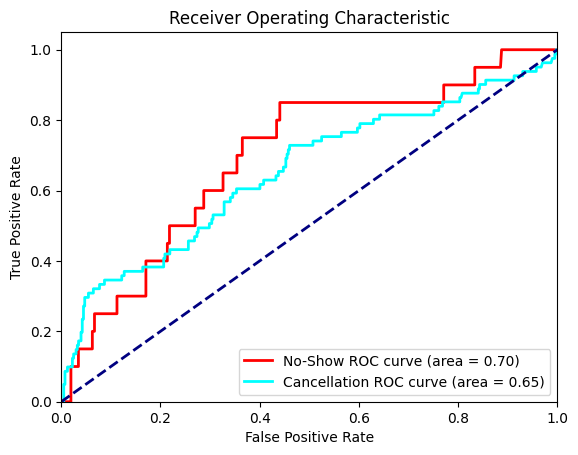

In [29]:
# %% Get models AUC-ROC scored

y_test_proba_n = cccv_n.predict_proba(x_test_n)[:, 1]
auc_roc_n = roc_auc_score(y_test_n, y_test_proba_n)
print('No-Show ' + f'AUC-ROC: {auc_roc_n}')

y_test_proba_c = cccv_c.predict_proba(x_test_c)[:, 1]
auc_roc_c = roc_auc_score(y_test_c, y_test_proba_c)
print('Cancellation ' + f'AUC-ROC: {auc_roc_c}')

# %% ROC_Curve

plt.figure()

# Plot No-Show Roc_curve
fpr, tpr, _ = roc_curve(y_test_n, y_test_proba_n)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label=f'No-Show ROC curve (area = {roc_auc:.2f})')

# Plot Cancellation Roc_curce
fpr, tpr, _ = roc_curve(y_test_c, y_test_proba_c)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='aqua', lw=2, label=f'Cancellation ROC curve (area = {roc_auc:.2f})')

# Plot line of no-discrimination
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# build plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

#### Cross-validation

Now we're going to cross-validation to evaluate and improve our model.<br>
<br>
I'm going to use StratifiedKFold to cross-validate the model using 2 k-folds.<br>
While the standard is to use 5 k-folds, we will only use 2 k-folds to significantly reduce the computation time.

In [30]:
# %% Cross-validate model
#    Note: using cv=2 to speed up method

# Cross-validation strategy
skf = StratifiedKFold(n_splits=2)
mean_fpr = np.linspace(0, 1, 100)

print(' ')
print('running cross-validation test on No-Show Model (approximately: 1 minute)')
print('...')

tprs = [] # Store true positive ratings
aucs = [] # Store AUCs

# For each split, fold data and measure auc
for train, test in skf.split(x_train_n, y_train_n):
    
    # assign folded data
    x_train_fold = x_train_n[train]
    y_train_fold = y_train_n[train]
    x_test_fold = x_train_n[test]
    y_test_fold = y_train_n[test]

    # Train and predict current fold
    cccv_n.fit(x_train_fold, y_train_fold)
    y_pred_proba_skf = cccv_n.predict_proba(x_test_fold)[:, 1]
    
    # calculate roc_curve for current fold and store true positive ratings
    fpr_skf, tpr_skf, _ = roc_curve(y_test_fold, y_pred_proba_skf)
    tprs.append(np.interp(mean_fpr, fpr_skf, tpr_skf))
    tprs[-1][0] = 0.0
    
    #calculate area under the ROC curve and store it
    roc_auc_skf = auc(fpr_skf, tpr_skf)
    aucs.append(roc_auc_skf)

# Calculate mean and standard deviation of the AUCs
mean_tpr_n = np.mean(tprs, axis=0)
mean_tpr_n[-1] = 1.0
mean_auc_n = auc(mean_fpr, mean_tpr_n)
std_auc_n = np.std(aucs)

print(' ')
print(f'Cross-validated No-Show AUC-ROC scores: {aucs}')
print(f'Mean No-Show AUC-ROC: {mean_auc_n}')

print(' ')
print('running cross-validation test on Cancellation Model (approximately: 1 minute)')
print('...')

tprs = [] # Store true positive ratings
aucs = [] # Store AUCs

# For each split, fold data and measure auc
for train, test in skf.split(x_train_n, y_train_n):
    
    # assign folded data
    x_train_fold = x_train_n[train]
    y_train_fold = y_train_n[train]
    x_test_fold = x_train_n[test]
    y_test_fold = y_train_n[test]

    # Train and predict current fold
    cccv_n.fit(x_train_fold, y_train_fold)
    y_pred_proba_skf = cccv_n.predict_proba(x_test_fold)[:, 1]
    
    # calculate roc_curve for current fold and store true positive ratings
    fpr_skf, tpr_skf, _ = roc_curve(y_test_fold, y_pred_proba_skf)
    tprs.append(np.interp(mean_fpr, fpr_skf, tpr_skf))
    tprs[-1][0] = 0.0
    
    #calculate area under the ROC curve and store it
    roc_auc_skf = auc(fpr_skf, tpr_skf)
    aucs.append(roc_auc_skf)

# Calculate mean and standard deviation of the AUCs
mean_tpr_c = np.mean(tprs, axis=0)
mean_tpr_c[-1] = 1.0
mean_auc_c = auc(mean_fpr, mean_tpr_c)
std_auc_c = np.std(aucs)

print(' ')
print(f'Cross-validated Cancellation AUC-ROC scores: {aucs}')
print(f'Mean Cancellation AUC-ROC: {mean_auc_c}')

print(' ')
print('Model Cross-validated')

 
running cross-validation test on No-Show Model (approximately: 1 minute)
...
 
Cross-validated No-Show AUC-ROC scores: [np.float64(0.9883807128910299), np.float64(0.9981672307492422)]
Mean No-Show AUC-ROC: 0.9901218060915796
 
running cross-validation test on Cancellation Model (approximately: 1 minute)
...
 
Cross-validated Cancellation AUC-ROC scores: [np.float64(0.9883807128910299), np.float64(0.9981672307492422)]
Mean Cancellation AUC-ROC: 0.9901218060915796
 
Model Cross-validated


#### --Compare Cross-validation AUC-ROC scores to first AUC-ROC scores--

Here is where we compare our original ROC curves to our new Cross-validated ROC curves.<br>
<br>
We will take the previous ROC curve graph and apply the new cross-validated ROC curves to it for comparison<br>
In the graph, we will see that the cross-validation significantly improves the model to make near-perfect predictions based on the data given.

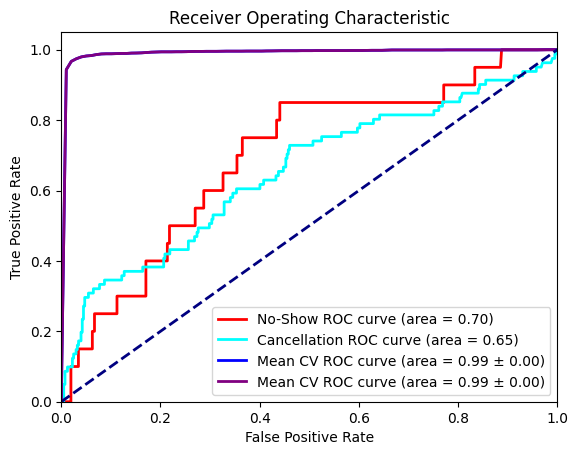

In [31]:
# %% Cross-validated ROC_Curve

plt.figure()

# Plot No-Show Roc_curve
fpr, tpr, _ = roc_curve(y_test_n, y_test_proba_n)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=2, label=f'No-Show ROC curve (area = {roc_auc:.2f})')

# Plot Cancellation Roc_curce
fpr, tpr, _ = roc_curve(y_test_c, y_test_proba_c)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='aqua', lw=2, label=f'Cancellation ROC curve (area = {roc_auc:.2f})')

# Plot Cross-validation Roc_curves
plt.plot(mean_fpr, mean_tpr_n, color='blue', lw=2, linestyle='-', label=f'Mean CV ROC curve (area = {mean_auc_n:.2f} ± {std_auc_n:.2f})')
plt.plot(mean_fpr, mean_tpr_c, color='purple', lw=2, linestyle='-', label=f'Mean CV ROC curve (area = {mean_auc_c:.2f} ± {std_auc_c:.2f})')

# Plot line of no-discrimination
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# build plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

#### --Feature Importance--

Here, we will show two horizontal bar graphs that show the feature importance for each model<br>
This model is how we discovered that the clients' zip code of residence is the most critical factor in dictating how likely they are to no-show or cancel.<br>
Using this information, we may infer that socio-economic conditions dictate the clients' behavior.

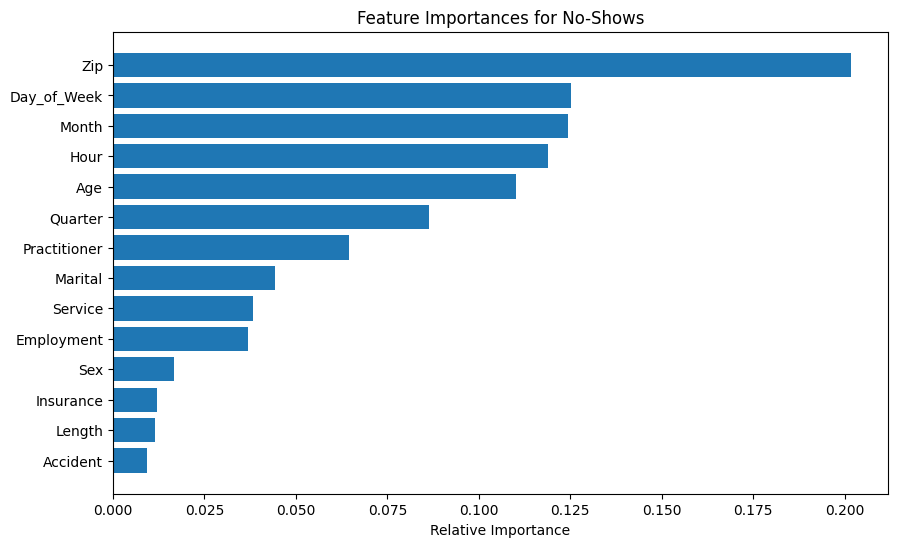

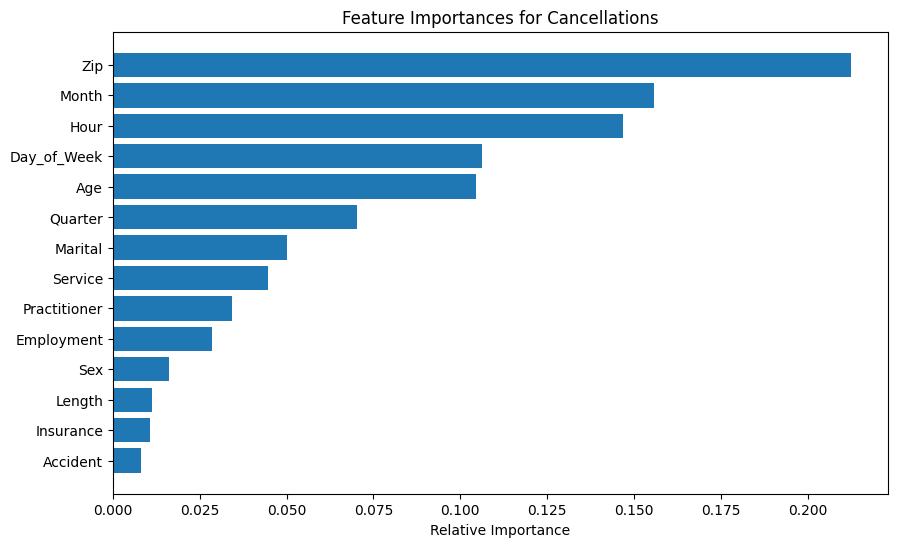

In [32]:
# %% Feature Importance Visualization

# Get Feature importances from estimator (Random Forest)
importances = cccv_n.calibrated_classifiers_[0].estimator.feature_importances_
indices = np.argsort(importances)

# Create plot
plt.figure(figsize=(10, 6))
plt.title('Feature Importances for No-Shows')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [x_n.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Get Feature importances from estimator (Random Forest)
importances = cccv_c.calibrated_classifiers_[0].estimator.feature_importances_
indices = np.argsort(importances)

# Create plot
plt.figure(figsize=(10, 6))
plt.title('Feature Importances for Cancellations')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [x_n.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### --Prediction Probabilities Distribution--

Here we will see the distribution of probabilities.<br>
We can see that both curves are hyperbolas with many outliers over 20% probability.
We can also see that both distributions are similar.

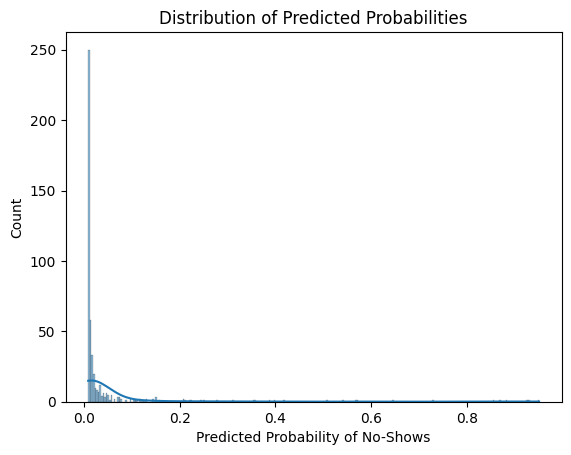

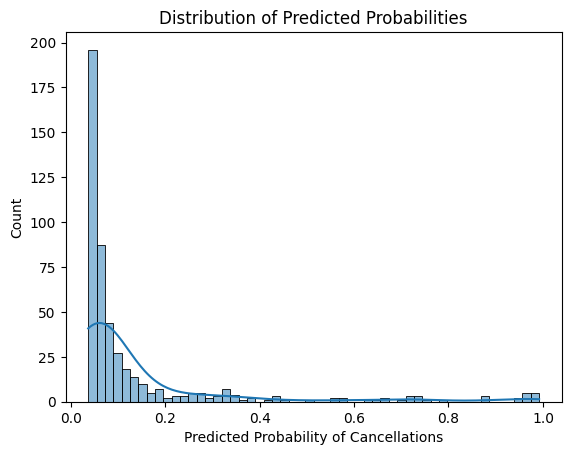

In [33]:
# %% Distribution of probabilities visualization

# Show distribution of probabilities
sns.histplot(y_test_proba_n, kde=True)
plt.xlabel('Predicted Probability of No-Shows')
plt.title('Distribution of Predicted Probabilities')
plt.show()

# Show distribution of probabilities
sns.histplot(y_test_proba_c, kde=True)
plt.xlabel('Predicted Probability of Cancellations')
plt.title('Distribution of Predicted Probabilities')
plt.show()

## Knowledge gained

From the data shown, we learned a few important things:
- Zip code is the most critical factor when considering how likely a client will no-show or cancel an appointment
- No-shows and cancellations make up a fifth of appointment data.
- There are four times as many cancels as no-shows.
- Appointment status by age group is mostly proportionate
- Most appointments are from clients around retirement age
- Retirement-age clients are the most likely to show up to appointments.
- The distribution of predicted probabilities between no-shows and cancellations are similar.

With this knowledge, we know that our hypothesis is wrong and that age is the most critical factor in determining how likely a client is to no-show or cancel an appointment.<br>
We discovered that the client's zip code of residence is the most critical determining factor.<br>
The reason for this could be due to socio-economic factors.

## Future Improvements

- Re-train and adjust machine-learning strategies as the size of the data increases.
- Develop strategies to automate data cleaning so that a human won't have correct inconsistencies before uploading the data.
- Develop a new strategy to standardize handling of null values when cleaning data to improve the consistency of training and make it less random.